<a href="https://colab.research.google.com/github/claudia-viaro/optimal_switching/blob/main/optimal_switching_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
np.random.seed(234198)
import itertools
import random
import time
import scipy.stats

import math
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as tdata

In [2]:
class stock:
    def __init__(self, drift, sigma, delta, spot, assets,  paths, periods,
         maturity, strike = 100,dividend=0):
        self.maturity = maturity
        self.strike = strike
        self.assets = assets
        self.sigma=sigma *np.ones(self.assets)
        self.delta=delta
        self.spot = spot*np.ones(self.assets)
        self.drift = drift - dividend
        self.paths = paths
        self.periods = periods
        self.dt = self.maturity / self.periods
    
    def GBM(self):
        
        dt = self.maturity / self.periods
        So_vec=self.spot*np.ones((1,S.paths, S.assets))
        
        Z=np.random.standard_normal((self.periods,self.paths, self.assets))
        s=self.spot*np.exp(np.cumsum((self.drift-0.5*self.sigma**2)*self.dt+self.sigma*np.sqrt(self.dt)*Z, axis=0))
        
        s=np.append(So_vec, s, axis=0)
        return s

In [3]:
class GBM:
  def __init__(self, drift, sigma, delta, spot, assets,  paths, periods,
         maturity, strike = 100,dividend=0):
    self.drift = drift - dividend
    self.sigma = sigma
    self.delta = delta
    self.spot = spot
    self.assets = assets
    self.paths = paths
    self.periods = periods
    self.maturity = maturity
    self.dt = self.maturity / self.periods
    self.df = math.exp(-drift * self.dt)
    self.strike = strike

  def simulate_process(self):
    paths = self.paths
    path = np.array([self.simulate_one_path() for i in range(paths)]) 
    return path.reshape(path.shape[2], path.shape[0], path.shape[1])

  def drift_fct(self,x):
    return  (self.drift-self.delta-0.5*self.sigma**2)* x

  def diffusion_fct(self,x):
    return self.sigma * x


  def simulate_one_path(self):
    path = np.empty((self.assets, self.periods+1))
    path[:, 0] = self.spot
    for k in range(1, self.periods+1):
      random_numbers = np.random.normal(0, 1, self.assets)
      dW =(random_numbers*np.sqrt(self.dt))
      previous_spots = path[:, k - 1]
      diffusion = (self.diffusion_fct(previous_spots))
      path[:, k] = (
          previous_spots
          + self.drift_fct(previous_spots)* self.dt
          + diffusion*dW) 
    return path  

In [4]:
def draw_stock_model(stockmodel):
    stock_paths = stockmodel

    # draw a path
    one_path = stock_paths[:, 0, 0]
    dates = np.array([i for i in range(len(one_path))])
    plt.plot(dates, one_path, label='stock path')
    plt.ylabel('Stock price')
    plt.ylabel('Time')
    plt.legend()
    return plt.show()   

(50, 500, 10)


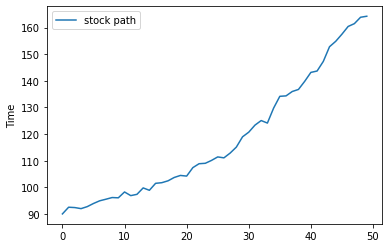

In [121]:
hyperparam_test_stock_models = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1,  'paths':500, 'periods': 49, 'maturity': 3., 'strike' : 100,'assets':10,  'spot':90,}
#S = GBM(**hyperparam_test_stock_models)
#X=S.simulate_process()

S=stock(**hyperparam_test_stock_models)
X=S.GBM()

print(X.shape) # (date, path, asset)
draw_stock_model(X) 

In [7]:
class Ftheta_NN(nn.Module):
  def __init__(self, assets):
    super(Ftheta_NN, self).__init__()
    H = assets + 40
    self.bn0 = nn.BatchNorm1d(num_features=assets)
    self.layer1 = nn.Linear(assets, H)
    self.leakyReLU = nn.LeakyReLU(0.5)
    self.Softplus = nn.Softplus()
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()
    self.relu = nn.ReLU()
    self.bn1 = nn.BatchNorm1d(num_features=H)
    self.layer2 = nn.Linear(H, H)
    self.bn2 = nn.BatchNorm1d(num_features=H)
    self.layer3 = nn.Linear(H, 1)
    self.bn3 = nn.BatchNorm1d(num_features=1)

  def forward(self, x):
    x = self.bn0(x)
    x = self.layer1(x)
    x = self.relu(x)
    x = self.bn2(x)
    x = self.layer3(x)
    x = self.sigmoid(x)
    return x



'''
class Ftheta_NN(nn.Module):
  def __init__(self, assets):
    super(Ftheta_NN, self).__init__()
    hidden_size = assets + 40
    self.l1 = nn.Linear(assets, hidden_size) 
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, hidden_size)
    self.l3 = nn.Linear(hidden_size, 1)  
    self.sigmoid=nn.Sigmoid()
    
  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)
    out = self.sigmoid(out)
    return out
'''
# set initial weights of a linear layer of the NN with uniform values and bias=0.01 (or choose zero initial weights)
def init_weights(m):
  if isinstance(m, torch.nn.Linear):
    torch.manual_seed(42)
    # torch.nn.init.zeros_(m.weight)
    torch.nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)

# Class "Profit"
This class contains various payoff and costs elements that define the reward. The final profit value is computed for each date and path.

### terminal reward
The terminal function $\Gamma$ is set to an option payoff function of choice regardless of the regime in which the process is at, in this case we have a Max Call. (other choices can be made as well). The terminal payoff is received at maturity, with no other costs nor payoffs.
\begin{equation}
\Gamma(n) = \Big(\max_{i \in \{1, \ldots, d \}} x^i - K   \Big)^{+} \tag{1}
\end{equation}

### running reward
The function $\Psi_q = (\Psi_q(n))_{n \in \mathbb{N}}$ represents the running reward received while in mode $q \in \mathbb{I}$. 
\begin{equation}
\Psi_q(n) = \Big[\Big(\max_{i \in \{1, \ldots, d\}} x^i_n - K   \Big)^{+} \Big]^{k_q} \;\;\;\;\; k \in \{.4, .7 \} \tag{2}
\end{equation}

### switching cost
The function $\gamma_{i, j} = (\gamma_{i, j}(n))_{n \in \mathbb{N}}$ with $i,j \in \mathbb{I} = \{0, 1 \}$ represents the cost for switching from mode $i \in \mathbb{I}$ to mode $j \in \mathbb{I}$.
\begin{equation} \tag{3}
\gamma_{0,0} \equiv \gamma_{1,1} \equiv 0 \\
\gamma_{0,1}(n) = \Big(\max_{i \in \{1, \ldots, d \}} x^i - K   \Big)^{+} + \delta  \;\;\;\;\; \delta = .7   \\ 
\gamma_{1, 0}(n) = \Big(\max_{i \in \{1, \ldots, d \}} x^i - K   \Big)^{+} 
\end{equation}

### the full expression for the profit
The entire expression for the value of the process at each time $n$ can be represented as: 
\begin{equation} \tag{4}
\check{Y}_{N}^i = \Gamma \mathbf{1}_{\{\tau = T\}} \\
\check{Y}_{n}^i = \Psi_i(n) + \max_{j \in \{0, 1 \}} 
\{- \gamma_{i, j}(\tau) + e^{-\rho h} \check{Y}_{\tau}^j   \}\mathbf{1}_{\{\tau < T\}} \;\;\;\;\;\;\;\;\;\; \text{for } n=N-1, \ldots, 0
\end{equation}


### Note
There are actually two profit classes:
- Profit_training (actually only the function "running") is used to compute $(\check{Y}_{n}^i, \check{Y}_{n}^j)$ at each date which is needed to in the loss function for the optimization of the parameters. As the optimization of the parameters will tell about switching/not I have to assume the profit can occur under both regimes [which is not fully correct then]
- Profit_testing (function "running") is used to compute $(\check{Y}_{n}^i), i \in \mathbb{I}$, once the new regime of the system is known  

In [22]:
'''
PROFIT TRAINING
'''

class Profit_training:
  def __init__(self, model):
    self.strike = model.strike
    self.regime = [0, 1]

  def terminal(self, X):
    terminal = np.max(X, axis=1) - self.strike
    return terminal.clip(0, None)  

  def g(self, date,path,X):
    max1=np.max(X[int(date) , path , : ]-S.strike)
    return np.exp(-S.drift*S.dt*date)*np.max(max1,0) 
  # 2 profit functions: terminal and running (running already includes all the costs)

  # switch is F_theta_train 
  def running(self, Y, date, path, X):
    gamma = np.array([-self.g(date, path, X), self.g(date, path, X) + 0.7])
    val=Y[date+1, path]  #S.df 
    r_benefit = self.g(date, path, X)
    return torch.from_numpy(r_benefit+val-gamma)  

'''
PROFIT TESTING
'''

class Profit_testing:
  def __init__(self, model):
    self.strike = model.strike

  def terminal(self, X):
    terminal = np.max(X, axis=1) - self.strike
    return terminal.clip(0, None)


  def g(self, date,path,X):
    X=torch.from_numpy(X).float()
    max1=torch.max(X[int(date) , path , : ].float()-S.strike)
    return np.exp(-S.drift*S.dt*date)*torch.max(max1,torch.tensor([0.0])) 
  # 2 profit functions: terminal and running (running already includes all the costs)

  # switch is F_theta_train 
  def running(self, Y, date, path, regime_path, S, X, switch, gamma):
    val=Y[date, path]- gamma  #S.df * 
    k = np.array([0.4, 0.7])
    new_regime = int(regime_path[date , path])
    exponent = k[new_regime]
    r_benefit = self.g(date, path, X)**exponent
    return val*int(switch[date, path])+r_benefit.numpy()     



# Optimization
This class contains the building blocks necessary to train the neural network which allows to perform a gradient ascent optimization algorithm on the parameters $\theta_n$, thus approximating the stopping times $\tau_{n+1}$.


In order to use the Back Propagation algorithm from Pytorch, the maximization task is transformed into minimizing the negative of the objective function.

\begin{equation}
L = -\frac{1}{M} \sum_{m=1}^M r_n^m (\theta_n) \tag{5}
\end{equation}

where we specified the reward function as being
\begin{equation}
r_n^m (\theta_n) = g(n, x_n^m)F^{\theta}(x_n^m)+ g(\bar{\tau}_{n+1}^m, x_{\bar{\tau}_{n+1}^m}^m)(1-F^{\theta}(x_n^m) ) \tag{6}
\end{equation}
where the $g()$ function is $(3)$.

### *To recap*
At time $n$ along path $m$, the reward is equal to $(2)$ taking into account the possible events of switching or not regime with probability given by $F^{\theta_n}$.

For a large number of paths $M$, we can say that $(1)$ approximates $\mathbb{E}[g(n, X_n)f^{\theta}(X_n)+ g(\tau_{n+1}, X_{\tau_{n+1}})(1-f^{\theta}(X_n) ) ]$. This is the function we optimize using gradient descent algorithm with respect to $\theta_n$. The algorithm outputs the probability values of switching $F^{\theta_n}$ for each date and for all paths considered, which we then translate into $0-1$ switching decisions $f^{\theta_n}$.

For each epoch, we use the set $\theta_n$ from the previous epoch (where the very first set is initialized according to a uniform distribution) to compute $F^{\theta_n}$. Then the updated ("loss.step()") $\theta_n$ are obtained via backpropagation by the gradient of the loss function ("loss.backward()"). 


### 2) evaluate_network
After training, the algorithm proceeds with the evaluation phase where it outputs the probability values of switching $F^{\theta_n}$. These corresponds to the object "stopping_probability".

### 3) stop
This function combines the two previous ones. It is called at every time step and it produces stopping probabilities for each date across all paths. The arguments it takes are those we see also in the loss function, hence:
- current profit $g(n, x_n^m)$
- future profit $g(\bar{\tau}_{n+1}^m, x_{\bar{\tau}_{n+1}^m}^m)$
- the entire process




In [26]:
'''
OPTIMIZATION AND LOSS FUNCTION
'''

def Optim(n,X,S, tau_n_plus_1, Y): # Y is Y_train, n is date, tau_n_plus_1 is tau_mat_test[date+1]
    epochs=50
    network=Ftheta_NN(S.assets)
    optimizer = torch.optim.Adam(network.parameters(), lr = 0.0001)

    for epoch in range(epochs):
        F = network.forward(torch.from_numpy(X[n]).float())  # probabilities
        reward = loss(F,S,X,n,tau_n_plus_1, Y) 
        reward.backward()
        optimizer.step()
    
    return F,network

def loss(y_pred,S, X, n, tau, Y): # input tau is tau_mat_test[date+1]
    profit = Profit_training(S)
    r_n=torch.zeros((S.paths, 2))
    for m in range(0,S.paths):
        tau_date = int(tau[m])

        r_n[m]=-(profit.running(Y, n,m,X)*y_pred[m] + profit.running(Y, tau_date,m,X)*(1-y_pred[m]))
    
    return(r_n.mean())


# Class "Training"
This class contains the main calculations to train the $\theta$ parameters

### price
First we start with some elements:
1. we simulate $d$ asset prices $\{X^i \}^d_{i=1}$ along $m$ paths according to a geometric Brownian motion process. We consider the iys discretized version on an equidistant time grid, $t_n = n \cdot T/N$ for $n=0, \ldots, N$:
\begin{equation} \tag{7}
x_{n,i}^m = x_{0,i} \cdot \exp \Big\{\sum_{k=0}^n \Big((r-\delta_i - \sigma_i^2 /2) \Delta t + \sigma_i \sqrt{\Delta t} \cdot Z_{k, i}^m  \Big) \Big\}
\end{equation}
where $(r-\delta_i) \in \mathbb{R}$ and $\sigma_i >0$ are the drift and volatility of the system $X$, $\Delta t =T/N$ and $Z_{k, i}^m \sim \mathcal{N}(0,1)$

2. we define the discount factor $\exp \{(r-\delta_i )\Delta t \}$
3. we create the "regime" object $\mathbb{I} = \{0, 1 \}$
4. we create the empty objects: "regime_path" that records the regime in which the process is at for every time step and path; "Y_train" that records the profit value for each time step and path; "F_theta_train" that records the presence of a stopping time


Then we can start the recursion:

*At maturity $N$*
1. we sample a regime to specify in which regime the process is and record it in "regime_path". The sampled regime is the same across all paths
2. we compute the profit at $N$ "final_payoff" $\check{Y}_{N}^i$ according to $(4)$ and record it in "Y_train"

### Note
Actually up to this point not all elements are needed for the training of the parameters. We only need tau_mat_train[model.periods,:], which is set =1 and Y_train

*Before maturity, for each date $ n=N-1, \ldots, 0$*
1. we obtain a stopping rule (called "mods") for each path using "Optim". this function computes the loss which requires calculating the profit at each date and at the date in which there has been a switching


In [122]:
class Training:
  def __init__(self, model, profit, payoff, nb_epochs=50):

    self.model = model # argument is S    
    self.profit = Profit_training(model)   #class profit. the argument is Profit, then you can call profit.terminal, etc
    self.payoff = Profit_testing(model)

  def price(self):
    model = self.model
    stock_paths = self.model.GBM()    
    disc_factor = np.math.exp((-model.drift) * model.maturity/(model.periods))
    
    # create empty objects to store values
    k = np.array([0.4, 0.7])
    regimes = [0, 1]
    regime_path=np.zeros((model.periods+1, model.paths)) # record at which regime we're at at each n
    Y_train=np.zeros((model.periods+1, model.paths))
    F_theta_train=np.zeros((model.periods+1,model.paths)) # record switching events for each n
    tau_mat_train=np.zeros((model.periods+1,model.paths))

    # at maturity N
    final_payoff = self.profit.terminal(stock_paths[-1, :, :])   # payoff of the last date for each path. 
    Y_train[model.periods, :]= final_payoff
    tau_mat_train[model.periods,:]=model.periods
    F_theta_train[model.periods,:]=1 # at maturity we switch (does it matter?)
    regime_path[model.periods, :] = random.sample(regimes, 1)[0] # sample a regime at maturity
    mods=[None]*model.periods
    print(stock_paths.shape[0] - 1, ":", np.min(F_theta_train[model.periods,:])," , ", np.max(F_theta_train[model.periods,:]),  " , ", len([1 for l in F_theta_train[model.periods,:] if l > 0.5])) # print the min/max stopping probabilities and the count of stopping times for each date
    
    # recursive calc. before maturity
    for date in range(stock_paths.shape[0] - 2, -1, -1):
      probs, mod_temp=Optim(date, stock_paths, model, torch.from_numpy((tau_mat_train[date+1]-1)).float(), Y_train)
      np_probs=probs.detach().numpy().reshape(model.paths)
      mods[date]=mod_temp
      print(date, ":", np.min(np_probs)," , ", np.max(np_probs),  " , ", len([1 for l in np_probs if l > 0.5])) # print the min/max stopping probabilities and the count of stopping times for each date
      F_theta_train[date,:]=(np_probs > 0.5)*1.0
      tau_mat_train[date,:]=np.argmax(F_theta_train, axis=0) 

      for m in range(0, self.model.paths):
         old_regime = regime_path[date +1, m]
         if  (int(F_theta_train[date, m]) == 1 ):
           regime_path[date , m] = regimes[~int(old_regime)] 
           gamma = self.profit.g(date, m, stock_paths) + 0.7
         else:
           regime_path[date , m] = old_regime
           gamma = -self.profit.g(date, m, X)
         Y_train[date, m] = self.payoff.running(Y = Y_train, date = int(tau_mat_train[date, m]), 
                                                path = m, regime_path = regime_path, S=self.model, 
                                                X = stock_paths,  switch = F_theta_train, 
                                                gamma = gamma)*np.exp(date-tau_mat_train[date,m]) 
       
    return mods 

# Class "Testing"
This class contains the main calculations to obtain the final $Y$ estimates

### price
First we start with the same elements as before:
1. we simulate new $d$ asset prices $\{X^i \}^d_{i=1}$ along $m$ paths according to a geometric Brownian motion process. We consider the its discretized version on an equidistant time grid, $t_n = n \cdot T/N$ for $n=0, \ldots, N$:
\begin{equation} \tag{7}
x_{n,i}^m = x_{0,i} \cdot \exp \Big\{\sum_{k=0}^n \Big((r-\delta_i - \sigma_i^2 /2) \Delta t + \sigma_i \sqrt{\Delta t} \cdot Z_{k, i}^m  \Big) \Big\}
\end{equation}
where $(r-\delta_i) \in \mathbb{R}$ and $\sigma_i >0$ are the drift and volatility of the system $X$, $\Delta t =T/N$ and $Z_{k, i}^m \sim \mathcal{N}(0,1)$

2. we define the discount factor $\exp \{(r-\delta_i )\Delta t \}$
3. we create the "regime" object $\mathbb{I} = \{0, 1 \}$
4. we create the empty objects: "regime_path" that records the regime in which the process is at for every time step and path; "Y_test" that records the profit value for each time step and path; "F_theta_test" that records the presence of a stopping time


Then we can start the recursion:

*At maturity $N$*
1. we sample a regime to specify in which regime the process is and record it in "regime_path". The sampled regime is the same across all paths
2. we compute the profit at $N$ "final_payoff" $\check{Y}_{N}^i$ according to $(4)$ and record it in "Y_test"

*Before maturity, for each date $ n=N-1, \ldots, 0$*
1. we record the stopping rules obtained in the training "F_theta_test"
3. we determine the current regime on the basis of the regime from the previous time step and if there has been or not a stopping time. Hence if at $n$ we have $F_n^{\theta}=1$ and $q_{n+1} = i$, we choose $q_n=j$. We then record this in "regime_path"
4. we compute $\check{Y}_{n}^i$ according to $(4)$, using "Profit_training.running()" appropriate for its current regime and record it under "Y_test"


In [123]:
L=stock(**hyperparam_test_stock_models)
pricingtraining = Training(L, Profit_training, Profit_testing,  nb_epochs=50)
mods = pricingtraining.price()

49 : 1.0  ,  1.0  ,  500
48 : 0.12098864  ,  0.9565978  ,  270
47 : 0.07019279  ,  0.87076414  ,  204
46 : 0.13750412  ,  0.81850845  ,  250
45 : 0.14740185  ,  0.8650574  ,  210
44 : 0.06878657  ,  0.8657932  ,  246
43 : 0.14017183  ,  0.85904807  ,  253
42 : 0.13695636  ,  0.8165579  ,  248
41 : 0.10191654  ,  0.8369526  ,  329
40 : 0.16202816  ,  0.81995773  ,  220
39 : 0.10457781  ,  0.84625906  ,  201
38 : 0.2349169  ,  0.8699009  ,  249
37 : 0.28473932  ,  0.78525025  ,  260
36 : 0.20600432  ,  0.76266325  ,  329
35 : 0.15796843  ,  0.82787746  ,  293
34 : 0.2220206  ,  0.7787263  ,  242
33 : 0.094433434  ,  0.94153035  ,  237
32 : 0.2033972  ,  0.7905355  ,  268
31 : 0.06269533  ,  0.8212386  ,  264
30 : 0.06707907  ,  0.9233184  ,  255
29 : 0.15287447  ,  0.79968244  ,  250
28 : 0.07169237  ,  0.9280179  ,  290
27 : 0.11267586  ,  0.84655565  ,  295
26 : 0.16367942  ,  0.8400256  ,  244
25 : 0.11083677  ,  0.8652763  ,  273
24 : 0.14954738  ,  0.8400418  ,  251
23 : 0.099177964

In [124]:
# Testing

class Testing:
  def __init__(self, model, profit, mods, nb_epochs=50):   
    self.model = model # argument is S   
    self.profit = Profit_testing(model)   #class profit. the argument is Profit, then you can call profit.terminal, etc
    self.mods = mods

  def price(self):
    stock_paths = self.model.GBM()    
    disc_factor = np.math.exp((-self.model.drift) * self.model.maturity/(self.model.periods))
    
    # create empty objects to store values
    k = np.array([0.4, 0.7])
    regimes = [0, 1]
    regime_path=np.zeros((self.model.periods+1, self.model.paths)) # record at which regime we're at at each n
    Y_test=np.zeros((self.model.periods+1, self.model.paths))
    Y_test_mean = np.zeros((self.model.periods+1))
    F_theta_test=np.zeros((self.model.periods+1,self.model.paths)) # record switching events for each n
    tau_mat_test=np.zeros((self.model.periods+1, self.model.paths))

    # at maturity N
    final_payoff = self.profit.terminal(stock_paths[-1, :, :])   # payoff of the last date for each path. 
    Y_test[self.model.periods, :]= final_payoff
    Y_test_mean[self.model.periods]=np.mean(Y_test[self.model.periods,:])
    tau_mat_test[self.model.periods,:]=self.model.periods
    F_theta_test[self.model.periods,:]=1 # at maturity we switch (does it matter?)
    regime_path[self.model.periods, :] = random.sample(regimes, 1)[0] # sample a regime at maturity

    # recursive calc. before maturity
    for date in range(stock_paths.shape[0] - 2, 0, -1):
       mod_curr=self.mods[date]
       probs=mod_curr(torch.from_numpy(stock_paths[date]).float())
       np_probs=probs.detach().numpy().reshape(self.model.paths)
       F_theta_test[date,:]=(np_probs > 0.5)*1.0
       tau_mat_test[date,:]=np.argmax(F_theta_test, axis=0) 
       print(date, ":", np.min(np_probs)," , ", np.max(np_probs))

       for m in range(0, self.model.paths):
         old_regime = regime_path[date +1, m]
         if  (int(F_theta_test[date, m]) == 1 ):
           regime_path[date , m] = regimes[~int(old_regime)] 
           gamma = self.profit.g(date, m, stock_paths) + 0.7
         else:
           regime_path[date , m] = old_regime
           gamma = -self.profit.g(date, m, X)
         Y_test[date, m] = self.profit.running(Y = Y_test, date = int(tau_mat_test[date, m]), 
                                                path = m, regime_path = regime_path, S=self.model, 
                                                X = stock_paths,  switch = F_theta_test, 
                                                gamma = gamma)*np.exp(date-tau_mat_test[date,m])

       Y_test_mean[date]=np.mean(Y_test[date,:])
    Y_std=np.std(Y_test, axis=1)
    Y_se=Y_std/(np.sqrt(self.model.paths))

    z=scipy.stats.norm.ppf(0.975)
    lower=Y_test_mean - z*Y_se
    upper=Y_test_mean + z*Y_se

    return Y_test_mean, upper, lower 

modelclass=stock(**hyperparam_test_stock_models)
price_testing = Testing(modelclass, Profit_testing, mods, nb_epochs=50)
Y_test_mean, upper, lower = price_testing.price()

48 : 0.10057986  ,  0.94109684
47 : 0.111574665  ,  0.93485457
46 : 0.08708411  ,  0.8014889
45 : 0.13457704  ,  0.8414847
44 : 0.1131964  ,  0.89762545
43 : 0.09752732  ,  0.8109539
42 : 0.18888347  ,  0.8348815
41 : 0.10729288  ,  0.81545466
40 : 0.14620286  ,  0.7964295
39 : 0.13251086  ,  0.8835031
38 : 0.258103  ,  0.79736376
37 : 0.26914605  ,  0.8938743
36 : 0.2420789  ,  0.80385834
35 : 0.15387474  ,  0.84151125
34 : 0.23767115  ,  0.79101425
33 : 0.11730581  ,  0.91271186
32 : 0.13576642  ,  0.8763892
31 : 0.11832975  ,  0.8791024
30 : 0.07362508  ,  0.9387938
29 : 0.12824526  ,  0.82438284
28 : 0.10912105  ,  0.9572933
27 : 0.056551494  ,  0.8141464
26 : 0.19743502  ,  0.85030353
25 : 0.12900297  ,  0.9037959
24 : 0.18179229  ,  0.8457835
23 : 0.09775796  ,  0.91160756
22 : 0.10001394  ,  0.8603608
21 : 0.10505166  ,  0.87161326
20 : 0.16557835  ,  0.9072985
19 : 0.2065747  ,  0.82304555
18 : 0.2347962  ,  0.7996144
17 : 0.115134  ,  0.9096887
16 : 0.14371255  ,  0.8555953
15

Text(0, 0.5, 'Value')

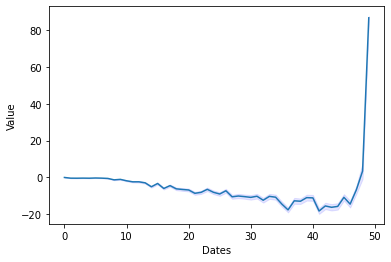

In [125]:
dates = np.array([i for i in range(len(Y_test_mean))])
fig, ax = plt.subplots()
ax.plot(dates,Y_test_mean)
ax.fill_between(dates, (lower), (upper), color='b', alpha=.1)
plt.xlabel("Dates")
plt.ylabel("Value")

In [112]:
'''

if you need to check
'''


'''
model =S # argument is S    
profit = Profit_training(model)   #class profit. the argument is Profit, then you can call profit.terminal, etc
payoff = Profit_testing(model)


stock_paths = model.GBM()    
disc_factor = np.math.exp((-model.drift) * model.maturity/(model.periods))

# create empty objects to store values
k = np.array([0.4, 0.7])
regimes = [0, 1]
regime_path=np.zeros((model.periods+1, model.paths)) # record at which regime we're at at each n
Y_train=np.zeros((model.periods+1, model.paths))
F_theta_train=np.zeros((model.periods+1,model.paths)) # record switching events for each n
tau_mat_train=np.zeros((model.periods+1,model.paths))

# at maturity N
final_payoff = profit.terminal(stock_paths[-1, :, :])   # payoff of the last date for each path. 
Y_train[model.periods, :]= final_payoff
tau_mat_train[model.periods,:]=model.periods
F_theta_train[model.periods,:]=1 # at maturity we switch (does it matter?)
regime_path[model.periods, :] = random.sample(regimes, 1)[0] # sample a regime at maturity
mods=[None]*model.periods

# recursive calc. before maturity
date =stock_paths.shape[0] - 2 
print(date) #4
tau_date = tau_mat_train[date+1]
print(tau_date) # date 5 has a stopping time
path=1

print(stock_paths)
print(stock_paths[date])
print(stock_paths[int(tau_date[path])])
print("ytrain", Y_train[date+1])


def g(date,path,X):
  max1=np.max(X[int(date) , path , : ]-model.strike)
  return np.exp(-S.drift*S.dt*date)*np.max(max1,0) 
  # 2 profit functions: terminal and running (running already includes all the costs)

  # switch is F_theta_train 
def running(Y, date, path, X):
  gamma = np.array([-g(date, path, X), g(date, path, X) + 0.7])
  val=Y[int(date)+1, path]  #S.df 
  r_benefit = g(date, path, X)
  return torch.from_numpy(r_benefit+val-gamma) 


print(Y_train[date+1, path])
print(final_payoff[path])
print(Y_train)

max1=np.max(stock_paths[int(date) , path , : ]-model.strike)
print(g(date, path, stock_paths))
print(Y_train[date+1, path])
f1 = running(Y_train, date,path,stock_paths)
f1 = running(Y_train, (tau_date-1)[path],path,stock_paths)

gamma = np.array([-g(date, path, stock_paths), g(date, path, stock_paths) + 0.7])
val=Y_train[date+1, path]  #S.df 
r_benefit = g(date, path, stock_paths)

print(torch.from_numpy(r_benefit+val-gamma) )

probs, mod_temp=Optim(date, stock_paths, model,torch.from_numpy((tau_mat_train[date+1]-1)).float(), Y_train)
'''

4
[5. 5. 5.]
[[[ 90.          90.        ]
  [ 90.          90.        ]
  [ 90.          90.        ]]

 [[ 99.07905922 103.57806807]
  [100.38894861 106.88277188]
  [107.29151179 103.05293966]]

 [[109.5435286  123.73519182]
  [106.77647699 117.02555865]
  [119.38120269 110.59058362]]

 [[128.34848654 138.24325326]
  [126.95467727 120.79626948]
  [131.98213637 125.18170845]]

 [[137.11698423 148.96496296]
  [137.73057898 149.31136512]
  [146.99443693 143.8669374 ]]

 [[157.90630671 176.25240056]
  [156.15525904 167.51124603]
  [145.27022895 159.75949508]]]
[[137.11698423 148.96496296]
 [137.73057898 149.31136512]
 [146.99443693 143.8669374 ]]
[[157.90630671 176.25240056]
 [156.15525904 167.51124603]
 [145.27022895 159.75949508]]
ytrain [76.25240056 67.51124603 59.75949508]
67.51124602880074
67.51124602880074
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.     